In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-books-reviews/books_data.csv
/kaggle/input/amazon-books-reviews/Books_rating.csv


In [2]:
ratings_df = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')
ratings_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [3]:
ratings_df = ratings_df[['Id','User_id','review/text','Title','review/score']]
ratings_df.head(1)

,Id,User_id,review/text,Title,review/score
0,1882931173,AVCGYZL8FQQTD,This is only for Julie Strain fans. It's a col...,Its Only Art If Its Well Hung!,4.0


In [4]:
ratings_df.rename(columns={'Id':'book_id','User_id':'user_id','review/text':'review','Title':'title','review/score':'rating'},inplace=True)

In [5]:
x = ratings_df.groupby('user_id').count()['review'] > 200
considerable_users = x[x].index
filtered_rating = ratings_df[ratings_df['user_id'].isin(considerable_users)]

y = filtered_rating.groupby('title').count()['review']>=50
famous_books = y[y].index
df = filtered_rating[filtered_rating['title'].isin(famous_books)]

df.head()

,book_id,user_id,review,title,rating
1747,B000N6DDJQ,AUM3YMZ0YRJE0,"WHen I finally started reading this classic, I...",The Scarlet Letter A Romance,5.0
1807,B000N6DDJQ,AMKZHBOK7VMQR,Hawthorne wrote a masterful work of historical...,The Scarlet Letter A Romance,5.0
1820,B000N6DDJQ,AWLFVCT9128JV,I don't suppose anything can ruin a book more ...,The Scarlet Letter A Romance,4.0
1829,B000N6DDJQ,ABN5K7K1TM1QA,"""All have sinned and fall short of the glory o...",The Scarlet Letter A Romance,5.0
1830,B000N6DDJQ,A3IKBHODOTYYHM,I think the many readers who were forced to pa...,The Scarlet Letter A Romance,4.0


In [6]:
df = df.reset_index()

In [7]:
df.shape

(17115, 6)

In [8]:
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
from nltk.sentiment import SentimentIntensityAnalyzer

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
# Calculate sentiment scores for each review
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [10]:
# Normalize the sentiment scores to be between 0 and 1
df['sentiment'] = (df['sentiment'] - df['sentiment'].min()) / (df['sentiment'].max() - df['sentiment'].min())

In [11]:
df = df.loc[~((df.rating.isin([1,2])) & (df['sentiment'] > 0.6))]
df = df.loc[~((df.rating.isin([4,5])) & (df['sentiment'] < 0.6))]

In [12]:
df.shape

(13824, 7)

In [13]:
# Combine the rating and sentiment scores into a single score
df['hybrid_score'] = df['rating'] * df['sentiment']

In [14]:
df.head()

,index,book_id,user_id,review,title,rating,sentiment,hybrid_score
0,1747,B000N6DDJQ,AUM3YMZ0YRJE0,"WHen I finally started reading this classic, I...",The Scarlet Letter A Romance,5.0,0.986494,4.932470
1,1807,B000N6DDJQ,AMKZHBOK7VMQR,Hawthorne wrote a masterful work of historical...,The Scarlet Letter A Romance,5.0,0.923916,4.619579
2,1820,B000N6DDJQ,AWLFVCT9128JV,I don't suppose anything can ruin a book more ...,The Scarlet Letter A Romance,4.0,0.960382,3.841529
3,1829,B000N6DDJQ,ABN5K7K1TM1QA,"""All have sinned and fall short of the glory o...",The Scarlet Letter A Romance,5.0,0.999200,4.995998
5,1833,B000N6DDJQ,A3KF4IP2MUS8QQ,The Scarlet Letter is truly one of literature'...,The Scarlet Letter A Romance,5.0,0.810215,4.051073


In [15]:
df.to_csv('nltk_ratings.csv',index=False)

In [16]:
df = pd.read_csv('/kaggle/working/nltk_ratings.csv')
df.head()

,index,book_id,user_id,review,title,rating,sentiment,hybrid_score
0,1747,B000N6DDJQ,AUM3YMZ0YRJE0,"WHen I finally started reading this classic, I...",The Scarlet Letter A Romance,5.0,0.986494,4.932470
1,1807,B000N6DDJQ,AMKZHBOK7VMQR,Hawthorne wrote a masterful work of historical...,The Scarlet Letter A Romance,5.0,0.923916,4.619579
2,1820,B000N6DDJQ,AWLFVCT9128JV,I don't suppose anything can ruin a book more ...,The Scarlet Letter A Romance,4.0,0.960382,3.841529
3,1829,B000N6DDJQ,ABN5K7K1TM1QA,"""All have sinned and fall short of the glory o...",The Scarlet Letter A Romance,5.0,0.999200,4.995998
4,1833,B000N6DDJQ,A3KF4IP2MUS8QQ,The Scarlet Letter is truly one of literature'...,The Scarlet Letter A Romance,5.0,0.810215,4.051073


In [17]:
from surprise import NMF, SVD
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [18]:
# load data from a file
reader = Reader(line_format='user item rating', sep=',')

In [19]:
data = Dataset.load_from_df(df[['user_id', 'book_id', 'hybrid_score']], reader=reader)

In [20]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)

In [21]:
raw_ratings = data.raw_ratings
raw_ratings[:5]

[('AUM3YMZ0YRJE0', 'B000N6DDJQ', 4.9324696113250965, None),
 ('AMKZHBOK7VMQR', 'B000N6DDJQ', 4.619578810464709, None),
 ('AWLFVCT9128JV', 'B000N6DDJQ', 3.84152868790956, None),
 ('ABN5K7K1TM1QA', 'B000N6DDJQ', 4.995998199189636, None),
 ('A3KF4IP2MUS8QQ', 'B000N6DDJQ', 4.051072982842279, None)]

In [22]:
# Train NMF model
model = NMF(n_factors=20, random_state=42)
model.fit(trainset)

In [23]:
# Make predictions on test set
predictions = model.test(testset)

In [24]:
# Evaluate model
rmse = accuracy.rmse(predictions)

RMSE: 0.6504


In [25]:
import matplotlib.pyplot as plt
# %matplotlib.inline

rmse_lst = []

for i in range(10,70,10):
    model = NMF(n_factors=i,random_state=42)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_lst.append(rmse)

RMSE: 0.7846
RMSE: 0.6504
RMSE: 0.6318
RMSE: 0.6767
RMSE: 0.7014
RMSE: 0.7389


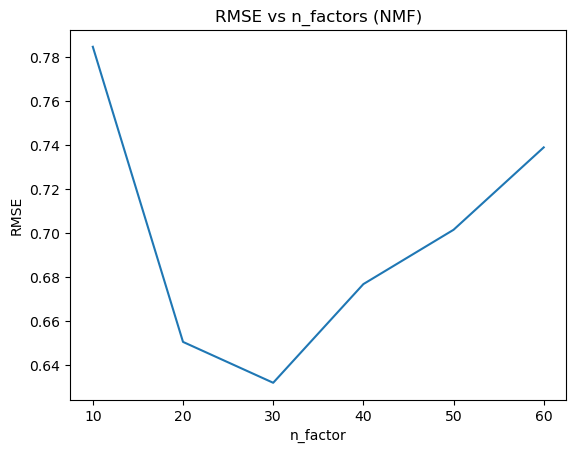

In [26]:
x = range(10,70,10)
y = rmse_lst

plt.plot(x, y)
plt.title('RMSE vs n_factors (NMF)')
plt.xlabel('n_factor')
plt.ylabel('RMSE')
plt.show()

In [27]:
from collections import defaultdict

In [28]:
def precision_recall_at_k(predictions, k=10, threshold=3):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [29]:
predictions[:5]

[Prediction(uid='A1BA72K4VK1UN1', iid='B000N6DGGQ', r_ui=1.0161072482617175, est=2.497676999562239, details={'was_impossible': False}),
 Prediction(uid='A3QW09WANRS6BZ', iid='1576467449', r_ui=3.9539792906808064, est=4.822367562281591, details={'was_impossible': False}),
 Prediction(uid='A21VR7M8O55EF6', iid='B000K6AVQC', r_ui=4.992996848581862, est=5, details={'was_impossible': False}),
 Prediction(uid='AFYYHRPSFBLWS', iid='B000P91JYW', r_ui=4.979240658296234, est=4.634615239008092, details={'was_impossible': False}),
 Prediction(uid='A22DUZU3XVA8HA', iid='B000H6XJVY', r_ui=4.586814066329849, est=5, details={'was_impossible': False})]

In [30]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2.5)

In [31]:
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.9751537515375153
0.6304167694881463


In [32]:
# Get the user ID for whom you want to make recommendations
user_id = 'A1X8VZWTOG8IS6'

# Get the list of all items (books) in the dataset
items = df['book_id'].unique()

# Predict the rating the user would give to each item and store in a dictionary
item_ratings = {}
for item in items:
    predicted_rating = model.predict(user_id, item).est
    item_ratings[item] = predicted_rating

# Sort the items by predicted rating in descending order and select the top 5
top_items = sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 recommended books
for i, item in enumerate(top_items):
    print(f"{i+1}. {item[0]}({df[df['book_id']==item[0]].iloc[0].title}) with predicted rating of {item[1]:.2f}")

1. B000PG70MK(The Hitchhiker's Guide to the Galaxy) with predicted rating of 5.00
2. B000BKUZYA(The Hitchhiker's Guide to the Galaxy) with predicted rating of 5.00
3. B0009JKV9W(The Hitchhiker's Guide to the Galaxy) with predicted rating of 5.00
4. B000GRNWSY(The Hitchhiker's Guide to the Galaxy) with predicted rating of 5.00
5. B000IOKF8U(Alice"s Adventures in Wonderland) with predicted rating of 4.49


In [33]:
# Train NMF model
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

In [34]:
# Evaluate the model on the test set
from surprise import accuracy
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.7411


In [35]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2)
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.9703567035670357
0.6292472670963192
